# Apply PCP to MVBS data

Here we use algorithms implemented by [ShunChi100](https://github.com/ShunChi100/RobustPCA/) to apply PCP (Principal Component Pursuit, or Robust Pricipal Component Analysis) to the MVBS data, and save the low-rank and sparse components into a netcdf file that will be easy to use and plot later.

The package can be installed by:
```
$ pip install fbpca
$ pip install git+https://github.com/ShunChi100/RobustPCA
```
Note `fbpca` is required to be installed first.

## Load data

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [5]:
MVBS_path = '../data/'
MVBS_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected.nc'

In [6]:
MVBS = xr.open_dataset(os.path.join(MVBS_path, MVBS_file))
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 ...
    range      (ping_time, range_bin) float64 ...

Reorder the frequency dimension:

In [7]:
MVBS = MVBS.reindex({'frequency': [38000,120000,200000]})

In [8]:
MVBS_vals = MVBS['MVBS'].values

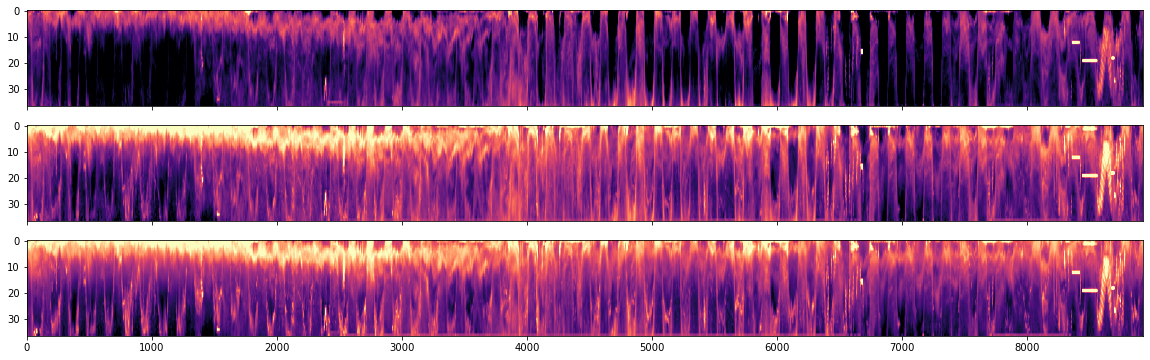

In [9]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(MVBS_vals[37:0:-1,:,iax],
                    aspect='auto',cmap='magma',vmin=-80,vmax=-50)

## Reshape matrix for decomposition

In [10]:
MVBS_vals.shape

(41, 8928, 3)

Given the dimension of `MVBS_vals`, we know that we need to reorder the dimensions and then reshape to get to the 2D matrix form we can use for PCP and sPCP decomposition.

We know our dataset has 3 frequencies, 41 range bins, 62 days, and 144 averaged ping bins with each day.

In [11]:
MVBS_vals_reshape = np.moveaxis(MVBS_vals,[0,1,2],[1,2,0]).reshape(3,41,62,144)

In [12]:
MVBS_vals_reshape.shape

(3, 41, 62, 144)

Sanity check by plotting out day 0:

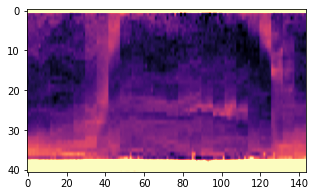

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5,3),sharex=True)
im = plt.imshow(MVBS_vals_reshape[0,:,0,:],aspect='auto',cmap='magma',vmin=-80,vmax=-50)

Further reshape to get to `[62 x 3*144*37]`, note the last number is 37 instead of 41 because we want to exclude the first range_bin immediately above the echosounder and the 3 range bins dominated by the sea surface reflection.

In [14]:
np.moveaxis(MVBS_vals_reshape[:,37:0:-1,:,:],[0,1,2],[1,2,0]).shape

(62, 3, 37, 144)

In [15]:
MVBS_for_PCP = np.moveaxis(MVBS_vals_reshape[:,37:0:-1,:,:],[0,1,2],[1,2,0]).reshape([62,-1])
MVBS_for_PCP.shape

(62, 15984)

## PCP decomposition

In [16]:
from RobustPCA.rpca import RobustPCA

In [17]:
rpca = RobustPCA()

Default parameters for `rpca` are:
```python
lamb=None, 
mu=None, 
max_rank=None, 
tol=1e-6, 
max_iter=100, 
use_fbpca=False, 
fbpca_rank_ratio=0.2
```

These parameters are well-documented [in the code](https://github.com/ShunChi100/RobustPCA/blob/master/RobustPCA/rpca.py)

Here we first run the default parameters:

In [18]:
rpca.fit(MVBS_for_PCP)
L_rpca = rpca.get_low_rank()
S_rpca = rpca.get_sparse()

Not converged!
Total error: 15.456207, allowed tolerance: 0.000001


In [19]:
mu = 10000*np.prod(MVBS_for_PCP.shape)/4.0/np.sum(np.abs(MVBS_for_PCP))

And then increase `max_iter`

In [20]:
rpca = RobustPCA(max_iter=100, mu = mu)
rpca.fit(MVBS_for_PCP)
L_rpca = rpca.get_low_rank()
S_rpca = rpca.get_sparse()

Not converged!
Total error: 0.001708, allowed tolerance: 0.000001


In [21]:
L_rpca.shape

(62, 15984)

In [22]:
L_rpca.reshape(62,3,37,144).shape

(62, 3, 37, 144)

Now we reshape the low-rank and sparse components back to the multi-dimensional array as the original MVBS dataset.

In [23]:
L_rpca_reorg = L_rpca.reshape(62,3,37,144)
S_rpca_reorg = S_rpca.reshape(62,3,37,144)

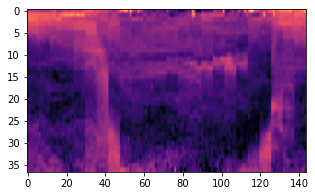

In [24]:
fig, ax = plt.subplots(1,1,figsize=(5,3),sharex=True)
im = plt.imshow(L_rpca_reorg[0,0,:,:],aspect='auto',cmap='magma',vmin=-80,vmax=-50)

Let's use the unfolding function from `tensorly` to help with plotting:

In [25]:
import tensorly as tl

### Low-rank component

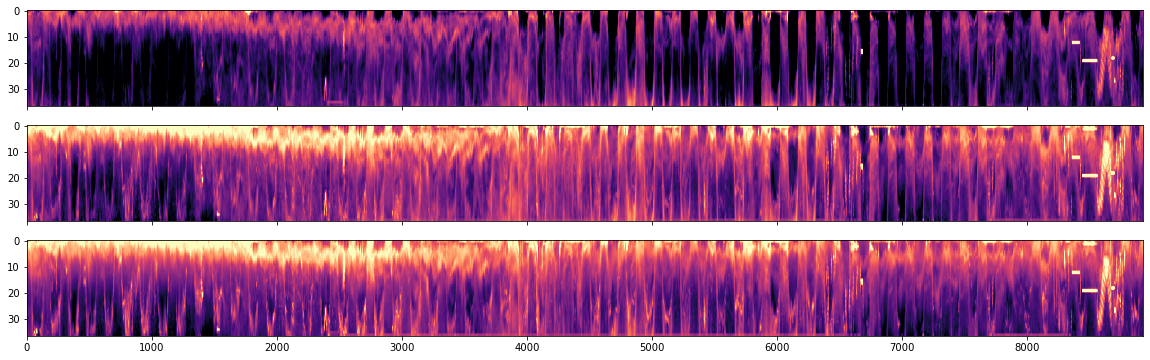

In [26]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(tl.unfold(tl.tensor(L_rpca_reorg[:,iax,:,:].squeeze()),mode=1),
                    aspect='auto',cmap='magma',vmin=-80,vmax=-50)

### Sparse component

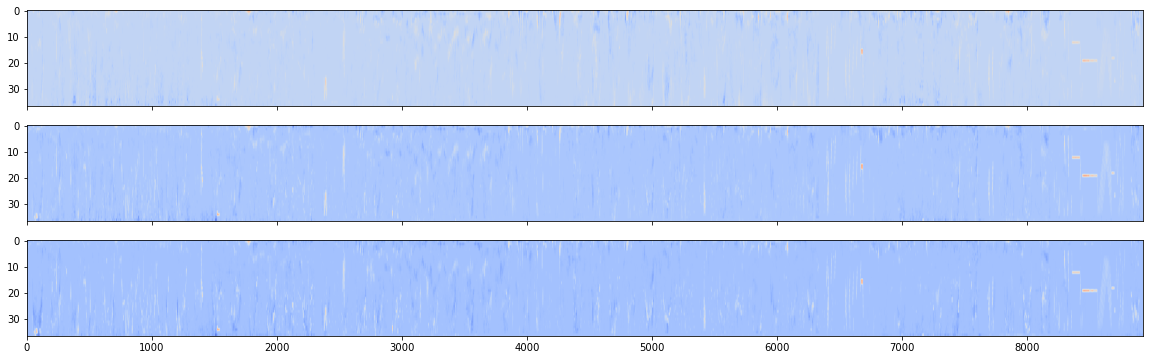

In [27]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(tl.unfold(tl.tensor(S_rpca_reorg[:,iax,:,:].squeeze()),mode=1),
                    aspect='auto',cmap='coolwarm')

## Save results as netCDF files

In [28]:
save_path = './data/'
rpca_filename = os.path.splitext(MVBS_file)[0] + '_rpca.nc'

In [29]:
import pandas as pd

### Save PCP results

In [30]:
ds_rpca = xr.Dataset({'low_rank': (['date','frequency','depth','hour'], L_rpca_reorg),
                      'sparse': (['date','frequency','depth','hour'], S_rpca_reorg)
                     },
                     coords={'date': pd.date_range('2015-08-17', periods=62),
                             'frequency': MVBS['frequency'].values,
                             'depth': MVBS['range'].isel(ping_time=0).values[37:0:-1],
                             'hour': np.arange(0,24,24/144)
                            })

In [31]:
ds_rpca

<xarray.Dataset>
Dimensions:    (date: 62, depth: 37, frequency: 3, hour: 144)
Coordinates:
  * date       (date) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
  * frequency  (frequency) int64 38000 120000 200000
  * depth      (depth) float64 184.0 179.0 174.0 169.0 ... 14.91 9.943 4.972
  * hour       (hour) float64 0.0 0.1667 0.3333 0.5 ... 23.33 23.5 23.67 23.83
Data variables:
    low_rank   (date, frequency, depth, hour) float64 -65.72 -64.35 ... -77.65
    sparse     (date, frequency, depth, hour) float64 -0.0003453 ... -0.02852

Sanity check using the first day:

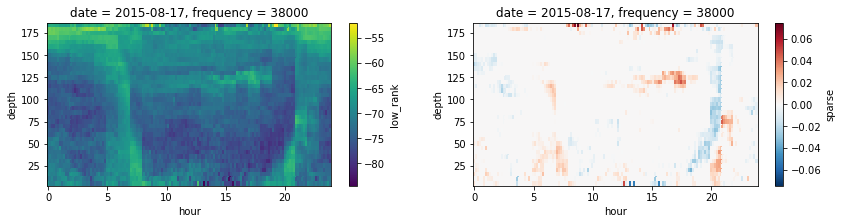

In [32]:
fig, ax = plt.subplots(1,2,figsize=(14,3))
ds_rpca['low_rank'].isel(frequency=0, date=0).plot(ax=ax[0])
ds_rpca['sparse'].isel(frequency=0, date=0).plot(ax=ax[1])
plt.show()

Save to file:

In [34]:
# ds_rpca.to_netcdf(os.path.join(save_path, rpca_filename))

### Some checks

Below are some checks to make sure the coordinates get set correctly.

In [37]:
#pd.date_range('2015-08-17', periods=62)

In [38]:
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * frequency  (frequency) int64 38000 120000 200000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 2.344 17.41 ... -52.79
    range      (ping_time, range_bin) float64 0.0 4.972 9.943 ... 193.9 198.9

Check `MVBS['range']` to construct depth vector:

In [39]:
MVBS['range'].isel(ping_time=0).values[37:0:-1]

array([183.95149565, 178.9798336 , 174.00817156, 169.03650951,
       164.06484747, 159.09318542, 154.12152338, 149.14986134,
       144.17819929, 139.20653725, 134.2348752 , 129.26321316,
       124.29155111, 119.31988907, 114.34822702, 109.37656498,
       104.40490294,  99.43324089,  94.46157885,  89.4899168 ,
        84.51825476,  79.54659271,  74.57493067,  69.60326862,
        64.63160658,  59.65994453,  54.68828249,  49.71662045,
        44.7449584 ,  39.77329636,  34.80163431,  29.82997227,
        24.85831022,  19.88664818,  14.91498613,   9.94332409,
         4.97166204])

In [40]:
MVBS['range'].isel(ping_time=0)

<xarray.DataArray 'range' (range_bin: 41)>
array([  0.        ,   4.97166204,   9.94332409,  14.91498613,
        19.88664818,  24.85831022,  29.82997227,  34.80163431,
        39.77329636,  44.7449584 ,  49.71662045,  54.68828249,
        59.65994453,  64.63160658,  69.60326862,  74.57493067,
        79.54659271,  84.51825476,  89.4899168 ,  94.46157885,
        99.43324089, 104.40490294, 109.37656498, 114.34822702,
       119.31988907, 124.29155111, 129.26321316, 134.2348752 ,
       139.20653725, 144.17819929, 149.14986134, 154.12152338,
       159.09318542, 164.06484747, 169.03650951, 174.00817156,
       178.9798336 , 183.95149565, 188.92315769, 193.89481974,
       198.86648178])
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
    ping_time  datetime64[ns] 2015-08-17

## Stable PCP Decomposition

In [41]:
from RobustPCA.spcp import StablePCP

In [42]:
sigma = 100

In [43]:
import scipy.linalg as la
noise_level = la.norm(MVBS_for_PCP,'fro')**2

In [44]:
mu0 = 0.70*noise_level

In [45]:
spcp = StablePCP(lamb = 0.05,mu0 = mu0, mu_fixed = True, sigma = 1, max_iter = 200)

In [46]:
spcp.fit(MVBS_for_PCP)
L_spcp = spcp.get_low_rank()
S_spcp = spcp.get_sparse()

Not converged within 200 iterations!
Total error: 0.006419, allowed tolerance: 0.000001


In [47]:
help(spcp)

Help on StablePCP in module RobustPCA.spcp object:

class StablePCP(builtins.object)
 |  StablePCP(lamb=None, mu0=None, mu0_init=1000, mu_fixed=False, mu_min=None, sigma=1, eta=0.9, max_rank=None, tol=1e-06, max_iter=100, use_fbpca=False, fbpca_rank_ratio=0.2, verbsome=False)
 |  
 |  Stable principal component pursuit (stable version of Robust PCA)
 |  
 |  Dimensionality reduction using Accelerated Proximal Gradient (APG)
 |  to decompose the input 2D matrix M into a lower rank dense 2D matrix L and sparse
 |  but not low-rank 2D matrix S and a noise term Z. Here the noise matrix Z = M-L-S and
 |  satisfying Frobenius norm ||Z|| < detla. The algorithm is tested to be effective
 |  under the assumption that Z is Gaussian noise.
 |  
 |  Parameters
 |  ----------
 |  lamb : positive float
 |      Sparse component coefficient.
 |      if user doesn't set it:
 |          lamb = 1/sqrt(max(M.shape))
 |      A effective default value from the reference.
 |  
 |  mu0 : positive float
 |    

In [48]:
L_spcp_reorg = L_spcp.reshape(62,3,37,144)
S_spcp_reorg = S_spcp.reshape(62,3,37,144)

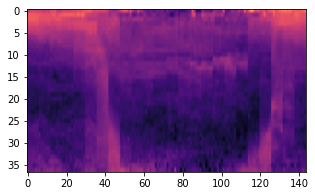

In [49]:
fig, ax = plt.subplots(1,1,figsize=(5,3),sharex=True)
im = plt.imshow(L_spcp_reorg[0,0,:,:],aspect='auto',cmap='magma',vmin=-80,vmax=-50)

In [50]:
import tensorly as tl

Text(4000, -100, 'Low Rank Component')

<Figure size 432x288 with 0 Axes>

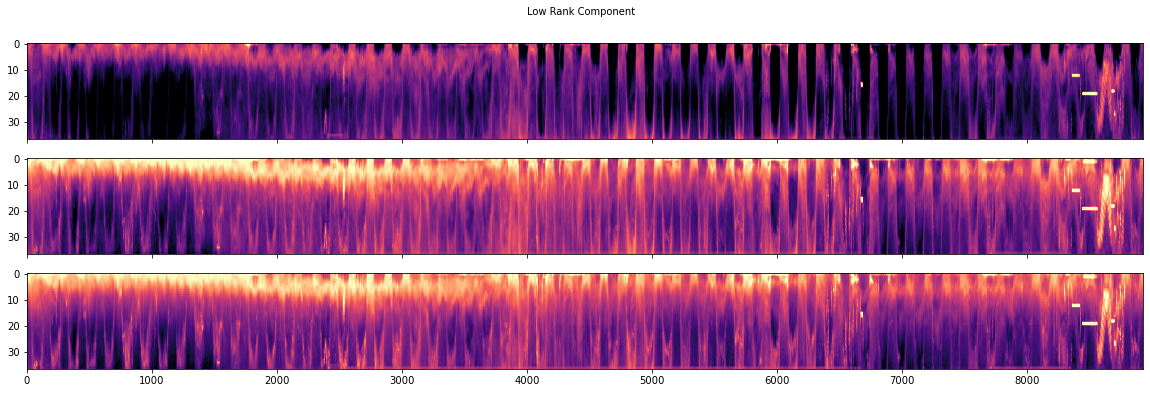

In [51]:
plt.figure()

fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(tl.unfold(tl.tensor(L_spcp_reorg[:,iax,:,:].squeeze()),mode=1),
                    aspect='auto',cmap='magma',vmin=-80,vmax=-50)
plt.text(4000,-100,'Low Rank Component')

Text(4000, -100, 'Sparse Component')

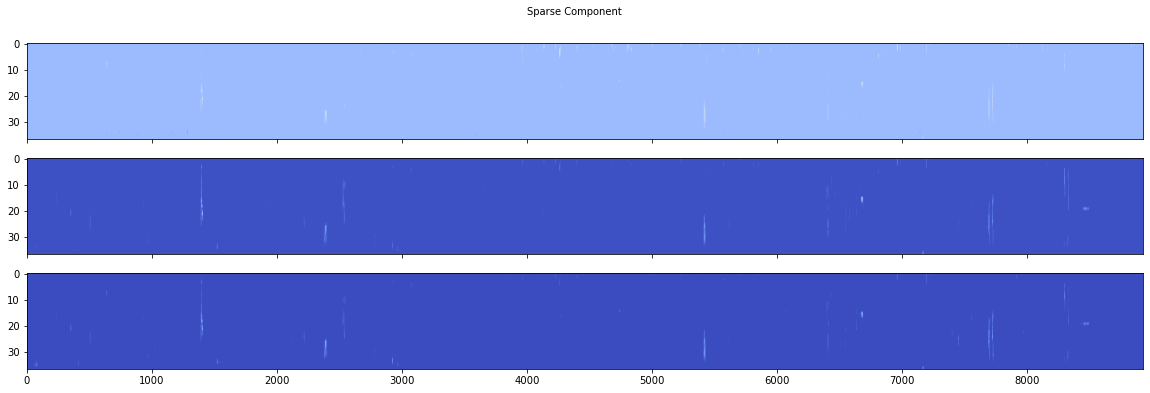

In [52]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(tl.unfold(tl.tensor(S_spcp_reorg[:,iax,:,:].squeeze()),mode=1),
                    aspect='auto',cmap='coolwarm')
    
plt.text(4000,-100,'Sparse Component')

In [53]:
error = MVBS_vals[37:0:-1,:,iax] - tl.unfold(tl.tensor(L_spcp_reorg[:,iax,:,:].squeeze()),mode=1)- tl.unfold(tl.tensor(S_spcp_reorg[:,iax,:,:].squeeze()),mode=1)

Text(4000, -100, 'Error Component')

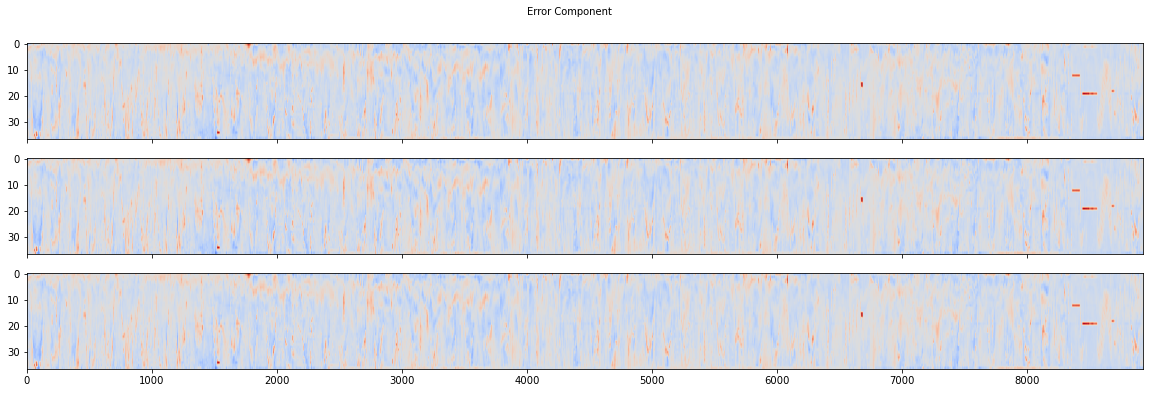

In [54]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(error,
                    aspect='auto',cmap='coolwarm')
plt.text(4000,-100,'Error Component')
